In [30]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.layers import (
    Input, Conv1D, concatenate,
    GlobalAveragePooling1D, Dense, BatchNormalization, Dropout, Add, Activation
)
from tensorflow.keras.models import Model


In [31]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_binary.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_binary.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_binary.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_binary.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_binary.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_binary.pkl")

### Segment into Windows

In [48]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'azimuth','pitch','roll']

def create_windows(X, y, window_size=100, step_size=50):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [49]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

### Encode Label

In [50]:
label_map = {'ADL': 0, 'FALL': 1}
y_train_windows_encoded = np.vectorize(label_map.get)(y_train_windows)
y_val_windows_encoded = np.vectorize(label_map.get)(y_val_windows)
y_test_windows_encoded = np.vectorize(label_map.get)(y_test_windows)

In [51]:

# 6. Build multi-stream Inception model
def multi_scale_inception_module(x, filters):
    return concatenate([
        Conv1D(filters//6, kernel_size=10, activation='relu', padding='same')(x),   # 0.1s
        Conv1D(filters//6, kernel_size=20, activation='relu', padding='same')(x),   # 0.2s
        Conv1D(filters//6, kernel_size=30, activation='relu', padding='same')(x),   # 0.3s
        Conv1D(filters//6, kernel_size=50, activation='relu', padding='same')(x),   # 0.5s
        Conv1D(filters//6, kernel_size=100, activation='relu', padding='same')(x),  # 1.0s
        Conv1D(filters//6, kernel_size=200, activation='relu', padding='same')(x),  # 2.0s
    ], axis=-1)

In [36]:
'''
def inception_module(x, filters):
    # 1×1 bottleneck
    bottleneck = Conv1D(filters//2, 1, activation='relu', padding='same')(x)
    bottleneck = BatchNormalization()(bottleneck)

    # parallel: small/medium/large/dilated
    b1 = Conv1D(filters//4, 1, activation='relu', padding='same')(bottleneck)
    b2 = Conv1D(filters//4, 3, activation='relu', padding='same')(bottleneck)
    b3 = Conv1D(filters//4, 5, activation='relu', padding='same')(bottleneck)
    b4 = Conv1D(filters//4, 9, activation='relu', padding='same')(bottleneck)
    b5 = Conv1D(filters//4, 3, dilation_rate=2, activation='relu', padding='same')(bottleneck)

    # apply BN + dropout on each branch (optional)
    branches = []
    for b in [b1, b2, b3, b4, b5]:
        b = BatchNormalization()(b)
        b = Dropout(0.2)(b)
        branches.append(b)

    # concat & residual
    concat = concatenate(branches, axis=-1)
    proj   = Conv1D(concat.shape[-1], 1, padding='same')(x)
    out    = Add()([concat, proj])
    return Activation('relu')(out)
    '''


"\ndef inception_module(x, filters):\n    # 1×1 bottleneck\n    bottleneck = Conv1D(filters//2, 1, activation='relu', padding='same')(x)\n    bottleneck = BatchNormalization()(bottleneck)\n\n    # parallel: small/medium/large/dilated\n    b1 = Conv1D(filters//4, 1, activation='relu', padding='same')(bottleneck)\n    b2 = Conv1D(filters//4, 3, activation='relu', padding='same')(bottleneck)\n    b3 = Conv1D(filters//4, 5, activation='relu', padding='same')(bottleneck)\n    b4 = Conv1D(filters//4, 9, activation='relu', padding='same')(bottleneck)\n    b5 = Conv1D(filters//4, 3, dilation_rate=2, activation='relu', padding='same')(bottleneck)\n\n    # apply BN + dropout on each branch (optional)\n    branches = []\n    for b in [b1, b2, b3, b4, b5]:\n        b = BatchNormalization()(b)\n        b = Dropout(0.2)(b)\n        branches.append(b)\n\n    # concat & residual\n    concat = concatenate(branches, axis=-1)\n    proj   = Conv1D(concat.shape[-1], 1, padding='same')(x)\n    out    = Add(

In [52]:
X_train_windows.shape[1]

100

In [53]:
# Input layer: 100 time-steps, 9 features
inp = Input(shape=(X_train_windows.shape[1], X_train_windows.shape[2]), name='sensor_input')

In [54]:
# Single branch (all 9 channels)
x = multi_scale_inception_module(inp, 96)
x = multi_scale_inception_module (x, 192)
x = multi_scale_inception_module (x, 192)

# Temporal pooling & classification head
x = GlobalAveragePooling1D()(x)
out = Dense(len(label_map), activation='softmax')(x)

model_inception = Model(inputs=inp, outputs=out)
model_inception.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model_inception.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sensor_input        │ (None, 100, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_54 (Conv1D)  │ (None, 100, 16)   │      1,456 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_55 (Conv1D)  │ (None, 100, 16)   │      2,896 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_56 (Conv1D)  │ (None, 100, 16)   │      4,336 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_57 (Conv1D)  │ (None, 100, 16)   │      7,216 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_58 (Conv1D)  │ (None, 100, 16)   │     14,416 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_59 (Conv1D)  │ (None, 100, 16)   │     28,816 │ sensor_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 100, 96)   │          0 │ conv1d_54[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_55[0][0],  │
│                     │                   │            │ conv1d_56[0][0],  │
│                     │                   │            │ conv1d_57[0][0],  │
│                     │                   │            │ conv1d_58[0][0],  │
│                     │                   │            │ conv1d_59[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_60 (Conv1D)  │ (None, 100, 32)   │     30,752 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_61 (Conv1D)  │ (None, 100, 32)   │     61,472 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 100, 32)   │     92,192 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 100, 32)   │    153,632 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 100, 32)   │    307,232 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_65 (Conv1D)  │ (None, 100, 32)   │    614,432 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 100, 192)  │          0 │ conv1d_60[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_61[0][0],  │
│                     │                   │            │ conv1d_62[0][0],  │
│                     │                   │            │ conv1d_63[0][0],  │
│                     │                   │            │ conv1d_64[0][0],  │
│                     │                   │            │ conv1d_65[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 100, 32)   │     61,472 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 100, 32)   │    122,912 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 100, 32)   │    184,352 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_69 (Conv1D)  │ (None, 100, 32)   │    307,232 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,838,466 (14.64 MB)

 Trainable params: 3,838,466 (14.64 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
from sklearn.utils import class_weight

In [56]:
# Compute class weights to handle imbalance
y_train_array = np.array(y_train_windows_encoded)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_array),
    y=y_train_array
)
class_weights = dict(enumerate(class_weights))


In [57]:
history = model_inception.fit(
    X_train_windows, y_train_windows_encoded,
    validation_data=(X_val_windows, y_val_windows_encoded),
    epochs=20,
    batch_size=64,
    class_weight=class_weights
)

Epoch 1/20
249/870 ━━━━━━━━━━━━━━━━━━━━ 6:27 624ms/step - accuracy: 0.5834 - loss: 2.2164

KeyboardInterrupt: 

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1618
Test Accuracy: 0.9487
1120/1120 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


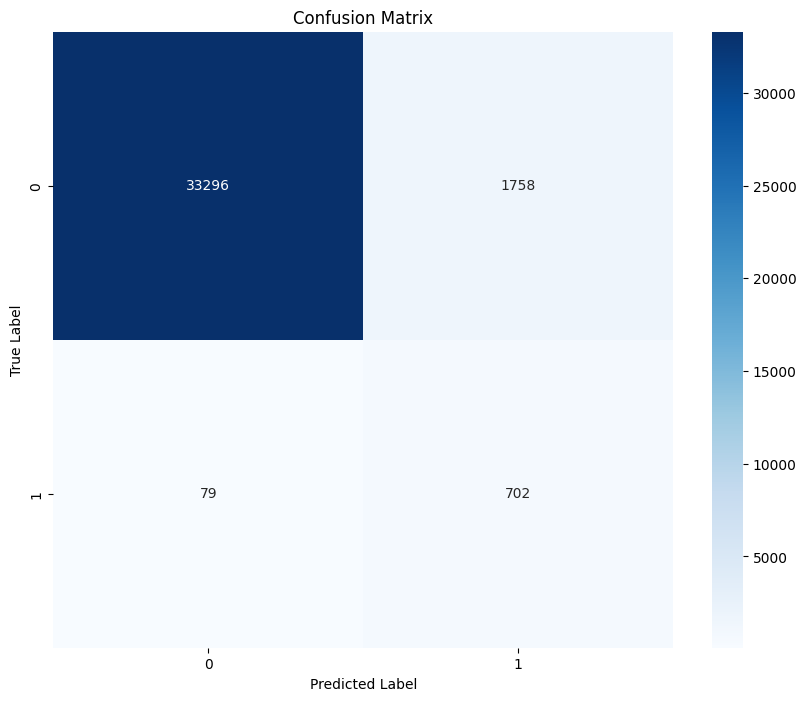

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     35054
           1       0.29      0.90      0.43       781

    accuracy                           0.95     35835
   macro avg       0.64      0.92      0.70     35835
weighted avg       0.98      0.95      0.96     35835

Weighted Precision: 0.9821
Weighted Recall: 0.9487
Weighted F1 Score: 0.9614


In [44]:
metrics = evaluate_model(model_inception, X_test_windows, y_test_windows_encoded)


### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)

    # --- CNN Blocks ---
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

    # --- LSTM Layer ---
    # return_sequences=True is important to preserve the temporal structure for the attention layer.
    x = LSTM(64, return_sequences=True)(x)

    # --- Self-Attention ---
    # The Attention layer computes a weighted sum of the LSTM outputs.
    # Using the same tensor for queries and keys/values implements self-attention.
    attn_output = Attention()([x, x])
    # Optionally, you can combine the attention output with the LSTM output.
    # Here, we simply use the attention output further.
    x = GlobalAveragePooling1D()(attn_output)

    # --- Dense Layers for Classification ---
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
